# NEURAL NETWORK

To run this document in Google Colab, please upload `ebnerd_small.zip` and `small_train_users_df_expanded.parquet` to the available Files for this document.

## DOCUMENT PREAMBLE

In [3]:
# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize  # Added label_binarize here
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import keras_tuner as kt

# Configure tqdm and matplotlib
tqdm.pandas()
plt.style.use("classic")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = "serif"
#plt.rcParams["figure.dpi"] = 200

# Set document parameters
data_version = "demo"
data_type = "train"

In [7]:
# Load data
def load_data(data_version, data_type, print_info=False):
    if data_type not in ["train", "validation"]:
        raise ValueError("data_type must be either 'train' or 'validation'")

    # Read parquet files into DataFrames
    behaviors_df = pd.read_parquet(f"./data/ebnerd_{data_version}/{data_type}/behaviors.parquet")
    history_df = pd.read_parquet(f"./data/ebnerd_{data_version}/{data_type}/history.parquet")
    articles_df = pd.read_parquet(f"./data/ebnerd_{data_version}/articles.parquet")

    # Print DataFrame info
    if print_info:
        for name, df in zip(
            [f"{data_type}/behaviors", f"{data_type}/history", "articles"],
            [behaviors_df, history_df, articles_df],
        ):
            print(f"--- '{name}' ---\n")
            print(df.info(), "\n")

    return behaviors_df, history_df, articles_df

# Load data
behaviors_df, history_df, articles_df = load_data(data_version, data_type, print_info=False)

# Load users_df
def load_users_df(print_info=False):
    # Define the path to the data
    file_path = f"data_processed/{data_version}_train_users_df_expanded.parquet"

    # Read the parquet file into a DataFrame
    users_df = pd.read_parquet(file_path)

    # Print DataFrame info if requested
    if print_info:
        print(users_df.info(), "\n")

    return users_df

# Load users_df
users_df = load_users_df(print_info=False)

# Filter rows in behaviors_df where 'article_ids_clicked' has more than 1 element
behaviors_df = behaviors_df[behaviors_df['article_ids_clicked'].apply(lambda x: len(x) <= 1)]

# Ensure 'article_ids_clicked' is treated as an integer
behaviors_df['article_ids_clicked'] = behaviors_df['article_ids_clicked'].astype('Int64')

# Merge history_df into behaviors_df
df = behaviors_df.merge(
    history_df,
    how='inner',
    on='user_id'
)

# Merge articles_df into df
df = df.merge(
    articles_df.add_prefix('clicked_article_'),
    how='inner',
    left_on='article_ids_clicked',
    right_on='clicked_article_article_id'
)

# Drop 'clicked_article_article_id' column
df = df.drop(columns=['clicked_article_article_id'])

# Merge users_df into df
df = df.merge(
    users_df,
    how='inner',
    on='user_id'
)

# Create a Series mapping article_ids_clicked to topics for quick lookup
article_topics_map = df.set_index('article_ids_clicked')['clicked_article_topics'].to_dict()

# Precompute the impression times window for each article
impressions_df = df[['impression_time', 'article_ids_clicked']]

# Create a dictionary to store trendiness scores
trendiness_scores = {}

# Pre-filter the DataFrame to reduce its size
impressions_df_sorted = impressions_df.sort_values(by='impression_time')

for article_ids_clicked, group in tqdm(impressions_df_sorted.groupby('article_ids_clicked')):
    topics = set(article_topics_map.get(article_ids_clicked, []))

    # Sort the group by impression time
    group = group.sort_values(by='impression_time')

    for impression_time in group['impression_time']:
        start_time = impression_time - pd.Timedelta(days=7)

        # Filter relevant impressions
        relevant_impressions = impressions_df_sorted[
            (impressions_df_sorted['impression_time'] >= start_time) &
            (impressions_df_sorted['impression_time'] < impression_time)
        ]

        # Calculate trendiness
        trendiness = relevant_impressions['article_ids_clicked'].apply(
            lambda x: not topics.isdisjoint(article_topics_map.get(x, set()))
        ).sum()

        trendiness_scores[(article_ids_clicked, impression_time)] = trendiness

# Map the trendiness scores back to the df
df['trendiness'] = df.apply(
    lambda row: trendiness_scores.get((row['article_ids_clicked'], row['impression_time']), 0), axis=1
)

# Precompute the impression times window for each article
impressions_df = df[['user_id', 'impression_time', 'article_ids_inview']]

# Convert 'article_ids_inview' to lists
def convert_to_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        return x.strip('[]').replace("'", "").split(', ')
    elif isinstance(x, np.ndarray):
        return x.tolist()
    else:
        return []

df['article_ids_inview'] = df['article_ids_inview'].apply(convert_to_list)

# seen_before_clicked calculation function
def calculate_seen_before_clicked(user_id, article_id, impression_time, hours=48):
    start_time = impression_time - pd.Timedelta(hours=hours)
    relevant_impressions = impressions_df[
        (impressions_df['user_id'] == user_id) &
        (impressions_df['impression_time'] >= start_time) &
        (impressions_df['impression_time'] < impression_time)
    ]
    seen_before_clicked = relevant_impressions['article_ids_inview'].apply(lambda x: article_id in x).sum()
    return seen_before_clicked

# Apply the function
df['seen_before_clicked'] = df.progress_apply(
    lambda row: calculate_seen_before_clicked(row['user_id'], row['article_ids_clicked'], row['impression_time']), axis=1
)

# Article Delay
df['article_delay'] = (df['impression_time'] - df['clicked_article_published_time']).dt.total_seconds() / 60
df['impression_hour'] = df['impression_time'].dt.hour
df['impression_day_of_week'] = df['impression_time'].dt.dayofweek

# Convert time of day and day of week to cyclical features
df['impression_hour_sin'] = np.sin(2 * np.pi * df['impression_hour'] / 24)
df['impression_hour_cos'] = np.cos(2 * np.pi * df['impression_hour'] / 24)
df['impression_day_of_week_sin'] = np.sin(2 * np.pi * df['impression_day_of_week'] / 7)
df['impression_day_of_week_cos'] = np.cos(2 * np.pi * df['impression_day_of_week'] / 7)

# Function to get NER clusters
def get_ner_clusters(article_ids, articles_df):
    clusters = articles_df[articles_df['article_id'].isin(article_ids)]['ner_clusters']
    return ' '.join([item for sublist in clusters for item in sublist])

# Extract NER clusters for each article_id_fixed
df['article_ner_clusters'] = df['article_ids_clicked'].apply(lambda ids: get_ner_clusters([ids], articles_df))

# Convert the clicked_article_ner_clusters to strings
df['clicked_article_ner_clusters_str'] = df['clicked_article_ner_clusters'].apply(lambda x: ' '.join(x))

# Combine all NER cluster strings for TF-IDF computation
corpus = pd.concat([df['clicked_article_ner_clusters_str'], df['article_ner_clusters']])

# Create a TF-IDF vectoriser and fit it to the corpus
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

# Calculate cosine similarity between clicked NER clusters and article NER clusters
def calculate_similarity(row_index):
    return cosine_similarity(tfidf_matrix[row_index], tfidf_matrix[row_index + len(df)])[0][0]

# Apply similarity calculation for each row
df['ner_similarity'] = [calculate_similarity(i) for i in range(len(df))]

100%|██████████| 24594/24594 [00:08<00:00, 2770.03it/s]


In [13]:
# Save the data to a parquet file
df.to_parquet(f'data_processed/{data_version}_savepoint.parquet', index=False)

In [14]:
# Load the savepoint parquet file
df = pd.read_parquet(f'/data_processed/{data_version}_savepoint.parquet')

In [15]:
# Ensure 'article_ids_inview' is a list of lists
df['article_ids_inview'] = df['article_ids_inview'].apply(lambda x: list(x) if isinstance(x, (list, np.ndarray)) else x)

# Generate target variable (index of clicked article in 'article_ids_inview')
def get_clicked_index(row):
    try:
        return row['article_ids_inview'].index(row['article_ids_clicked'])
    except ValueError:
        return -1  # If the clicked article is not in the inview list

df['clicked_index'] = df.apply(get_clicked_index, axis=1)

# Prepare input features
max_length = max(df['article_ids_inview'].apply(len))

# Pad the 'article_ids_inview' lists to a fixed length
X_inview = pad_sequences(df['article_ids_inview'].tolist(), maxlen=max_length, padding='post')

y = df['clicked_index'].values

# Prepare additional features
features = [
    'trendiness', 'seen_before_clicked', 'article_delay',
    'impression_hour_sin', 'impression_hour_cos',
    'impression_day_of_week_sin', 'impression_day_of_week_cos',
    'ner_similarity', 'clicked_article_sentiment_score'
]
X_other_features = df[features].values

# Standardise additional features
scaler = StandardScaler()
X_other_features = scaler.fit_transform(X_other_features)

# Combine features
X_combined = np.hstack((X_inview, X_other_features))

# Split data
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_combined, y, np.arange(len(df)), test_size=0.2, random_state=42
)

# Define a function to build the model
def build_model(hp):
    input_layer = Input(shape=(X_train.shape[1],))

    # Embedding layer
    embedding_layer = Embedding(
        input_dim=np.max(X_inview) + 1,
        output_dim=hp.Int('embedding_dim', min_value=4, max_value=16, step=4)
    )(input_layer[:, :max_length])

    # Attention layer
    attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
        key_dim=8
    )(embedding_layer, embedding_layer)

    flattened = Flatten()(attention_layer)
    concatenated = Concatenate()([flattened, input_layer[:, max_length:]])

    # Feed-forward neural network layers
    x = Dense(
        hp.Int('units_1', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(concatenated)
    x = Dropout(0.5)(x)

    x = Dense(
        hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(0.5)(x)

    # Additional FFNN layers
    x = Dense(
        hp.Int('units_3', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(0.5)(x)

    x = Dense(
        hp.Int('units_4', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_regularizer=l2(0.01)
    )(x)
    x = Dropout(0.5)(x)

    # Output layer
    output_layer = Dense(max_length, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='tuning_example'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Train the best model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the best model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Reloading Tuner from my_dir/tuning_example/tuner0.json
Epoch 1/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.0906 - loss: 4.5354 - val_accuracy: 0.1220 - val_loss: 2.7164
Epoch 2/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1159 - loss: 2.7801 - val_accuracy: 0.1128 - val_loss: 2.5724
Epoch 3/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1191 - loss: 2.6059 - val_accuracy: 0.1253 - val_loss: 2.5224
Epoch 4/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1257 - loss: 2.5530 - val_accuracy: 0.1192 - val_loss: 2.4892
Epoch 5/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1133 - loss: 2.5265 - val_accuracy: 0.1131 - val_loss: 2.4773
Epoch 6/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1249 - loss: 2.5053 - val_accuracy: 0.1253 - val_loss: 2.4594
Epoch 7/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1147 - loss: 2.5140 - val_accuracy: 0.1253 - val_loss: 2.4861
Epoch 8/20
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/

In [16]:
# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Find correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

for i in range(len(y_test)):
    if y_pred_classes[i] == y_test[i]:
        correct_predictions.append((i, y_pred_classes[i], y_test[i]))
    else:
        incorrect_predictions.append((i, y_pred_classes[i], y_test[i]))

# Create a test DataFrame using the original indices
df_test = df.iloc[test_indices]

# Print five correct predictions with details
print("\nSample Correct Prediction:\n")
for idx, pred, true in correct_predictions[:5]:
    # Retrieve the article IDs from the original DataFrame
    article_ids_inview = df_test.iloc[idx]['article_ids_inview']
    article_id_clicked = df_test.iloc[idx]['article_ids_clicked']

    # Get the predicted article ID
    predicted_article_id = article_ids_inview[pred]

    print(f"Sample Index: {idx}, Predicted Index: {pred}, True Index: {true}\n")
    print(f"Predicted Article ID: {predicted_article_id}, True Article ID: {article_id_clicked}\n")
    print("X_test:", X_test[idx])
    print("y_test:", y_test[idx])
    print()  # Add a blank line for readability

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Sample Correct Prediction:

Sample Index: 21, Predicted Index: 7, True Index: 7

Predicted Article ID: 9778843, True Article ID: 9778843

X_test: [ 9.77894200e+06  9.51298300e+06  9.77739700e+06  9.77884500e+06
  9.77821900e+06  9.48648600e+06  9.77890500e+06  9.77884300e+06
  9.77872200e+06  9.77892200e+06  9.77880400e+06  7.30665200e+06
  9.42017200e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00

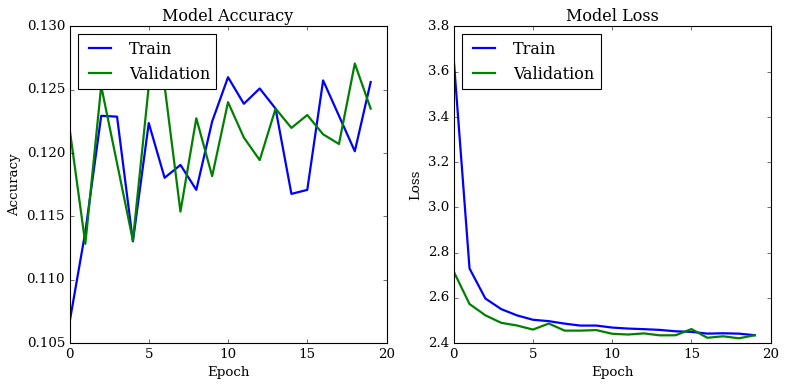

In [17]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], color='blue', lw=2)
ax[0].plot(history.history['val_accuracy'], color='green', lw=2)
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
ax[1].plot(history.history['loss'], color='blue', lw=2)
ax[1].plot(history.history['val_loss'], color='green', lw=2)
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


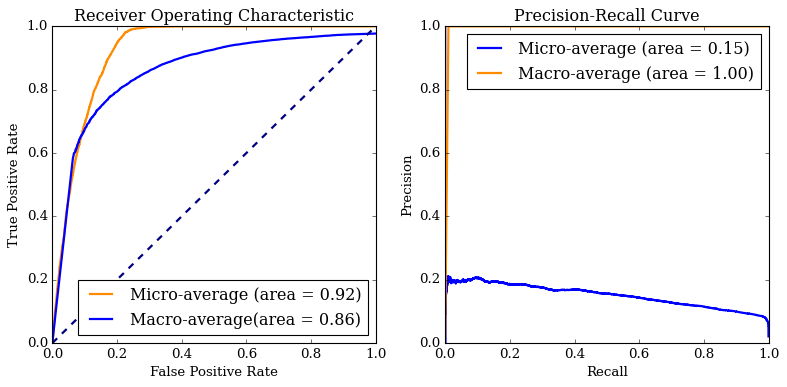

In [18]:
# Get the predicted probabilities for the test set
y_pred_proba = model.predict(X_test)

# Binarize the output
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

# Initialize dictionaries for ROC curve data
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    if np.sum(y_test_binarized[:, i]) > 0:  # Check for positive samples
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba[:, :n_classes].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    if i in fpr:  # Only include classes with valid ROC data
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(fpr)  # Average over the number of classes with valid data
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Calculate micro-average precision and recall
precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_proba[:, :n_classes].ravel())
average_precision_micro = auc(recall_micro, precision_micro)

# Calculate macro-average precision and recall
all_precisions = []
all_recalls = []

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    all_precisions.append(precision)
    all_recalls.append(recall)

# Interpolate the precision values for macro averaging
mean_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(mean_recall)

for i in range(len(all_precisions)):
    mean_precision += np.interp(mean_recall, all_recalls[i], all_precisions[i])

mean_precision /= len(all_precisions)  # Average over the number of classes
average_precision_macro = auc(mean_recall, mean_precision)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot ROC curve
ax[0].plot(fpr["micro"], tpr["micro"], label=f'Micro-average (area = {roc_auc["micro"]:.2f})', color='darkorange', lw=2)
ax[0].plot(fpr["macro"], tpr["macro"], label=f'Macro-average(area = {roc_auc["macro"]:.2f})', color='blue', lw=2)
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic')
ax[0].legend(loc='lower right')

# Plot Precision-Recall curve
ax[1].plot(recall_micro, precision_micro, label=f'Micro-average (area = {average_precision_micro:.2f})', color='blue', lw=2)
ax[1].plot(mean_recall, mean_precision, label=f'Macro-average (area = {average_precision_macro:.2f})', color='darkorange', lw=2)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()